In [ ]:
# Importar librerias

import pandas as pd
import matplotlib.pyplot as plt
import re
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tqdm import tqdm

In [ ]:
# Importar dataset
splits = {'train': 'data/train-00000-of-00001-5c45a0f6b5cce221.parquet', 'test': 'data/test-00000-of-00001-ba9f365147e3f1c4.parquet', 'valid': 'data/valid-00000-of-00001-1570766e652a3521.parquet'}
df = pd.read_parquet("hf://datasets/hacktoberfest-corpus-es/colmbian_spanish_news/" + splits["train"])

In [ ]:
df.head()

,news_id,news_url_absolute,news_init_date,news_final_date,news_title,news_text_content,entailment,category,__index_level_0__
0,8a673cad-5548-4991-981d-7b3dd37be9e7,https://semana.com/gente/articulo/en-una-cerem...,2022-07-03,2022-07-03,En una ceremonia “secreta” se casó la presenta...,El matrimonio se celebró en la ciudad de Barra...,1.0,gente,3008
1,c12930aa-d506-468a-bbe5-224a8154fcae,https://smoda.elpais.com/moda/actualidad/del-r...,2021-10-02,2021-10-02,Del relevo de Amancio Ortega al éxito de las m...,El principio del fin de Amaya Arzuaga. El muti...,1.0,innovación,4605
2,5449c762-d39f-465e-a0c9-32fc4feef27b,https://www.valoraanalitik.com/2021/01/22/codi...,2021-01-22,2021-01-22,Codirectora Soto: Colombia debe continuar refo...,En el marco del evento Perspectivas Colombia 2...,1.0,macroeconomia,3295
3,643e3e3a-6148-4781-ad0c-55711597fc8b,https://semana.com/vida-moderna/articulo/los-f...,2022-10-04,2022-10-04,Los factores por los que aumenta el nivel de á...,Cuando los niveles de ácido úrico son elevados...,1.0,gente,1192
4,ae8b6ce6-f554-4c17-8814-a137191ca253,https://elpais.com/diario/2005/09/17/catalunya...,2005-09-17,2005-09-17,Trampeando con la alianza de civilizaciones,"Me dirán que, ante el malismo de otros, bienve...",0.5,alianzas,942


In [ ]:
df_train = df[["news_title", "news_text_content", "category"]]
df_train.head()

,news_title,news_text_content,category
0,En una ceremonia “secreta” se casó la presenta...,El matrimonio se celebró en la ciudad de Barra...,gente
1,Del relevo de Amancio Ortega al éxito de las m...,El principio del fin de Amaya Arzuaga. El muti...,innovación
2,Codirectora Soto: Colombia debe continuar refo...,En el marco del evento Perspectivas Colombia 2...,macroeconomia
3,Los factores por los que aumenta el nivel de á...,Cuando los niveles de ácido úrico son elevados...,gente
4,Trampeando con la alianza de civilizaciones,"Me dirán que, ante el malismo de otros, bienve...",alianzas


In [ ]:
df_train.isnull().sum()

news_title           0
news_text_content    0
category             0
dtype: int64

In [ ]:
df_train["category"].unique()

array(['gente', 'innovación', 'macroeconomia', 'alianzas', 'reputacion',
       'regulaciones', 'infraesctructura', 'otros', 'sostenibilidad'],
      dtype=object)

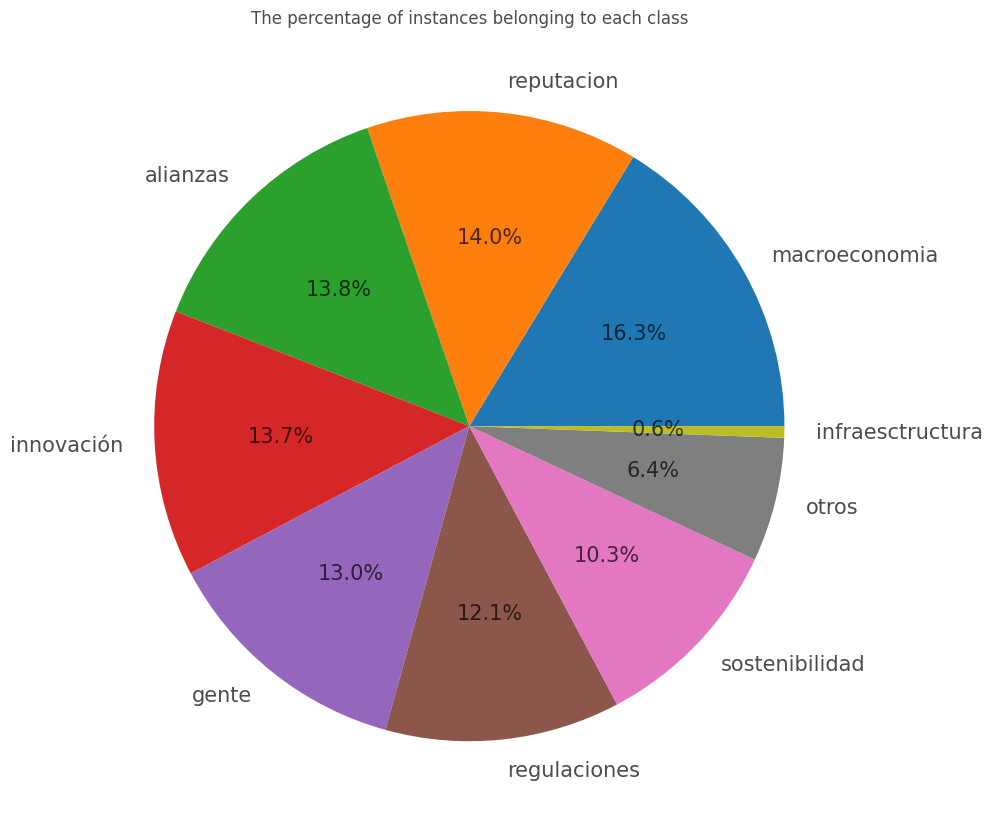

In [ ]:
plt.figure(figsize=(10, 10))
plt.pie(
    x=df_train.category.value_counts(),
    labels=df_train.category.value_counts().index,
    autopct='%1.1f%%',
    textprops={'fontsize': 15, 'alpha': 0.7}
)
plt.title('The percentage of instances belonging to each class', alpha=0.7)
plt.tight_layout()
plt.savefig("clases2.jpg", bbox_inches='tight')
plt.show()

In [ ]:
# Dataframes de testing y validación

df_test = pd.read_parquet("hf://datasets/hacktoberfest-corpus-es/colmbian_spanish_news/" + splits["test"])
df_test = df_test[["news_title", "news_text_content", "category"]]
df_val = pd.read_parquet("hf://datasets/hacktoberfest-corpus-es/colmbian_spanish_news/" + splits["valid"])
df_val = df_val[["news_title", "news_text_content", "category"]]

# Eliminamos la filas en las cuales se encuentre la categoría "Infraestructura"

def eliminar_filas(df):
    df.drop(df.loc[df["category"] == "infraesctructura"].index, inplace=True)
    return None

eliminar_filas(df_train)
eliminar_filas(df_val)
eliminar_filas(df_test)

<ipython-input-152-3a4e41b8071a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df.loc[df["category"] == "infraesctructura"].index, inplace=True)


In [ ]:
df_val["category"].unique()

array(['gente', 'innovación', 'macroeconomia', 'sostenibilidad',
       'regulaciones', 'reputacion', 'alianzas', 'otros'], dtype=object)

In [ ]:
# Preprocesamiento de texto
def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)
    texto = re.sub(r'[^a-záéíóúüñ0-9,.?!¡¿ ]', '', texto)
    return texto

df_train['news_title'] = df_train['news_title'].apply(limpiar_texto)
df_train['news_text_content'] = df_train['news_text_content'].apply(limpiar_texto)
df_val['news_title'] = df_val['news_title'].apply(limpiar_texto)
df_val['news_text_content'] = df_val['news_text_content'].apply(limpiar_texto)
df_test['news_title'] = df_test['news_title'].apply(limpiar_texto)
df_test['news_text_content'] = df_test['news_text_content'].apply(limpiar_texto)

<ipython-input-154-5fb3c400ea6d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['news_title'] = df_train['news_title'].apply(limpiar_texto)
<ipython-input-154-5fb3c400ea6d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['news_text_content'] = df_train['news_text_content'].apply(limpiar_texto)


In [ ]:
# Creación de labels númericos para las categorias
df_train['label'] = pd.factorize(df_train['category'])[0]
label_dict = dict(zip(df_train['category'], df_train['label']))
label_dict

<ipython-input-155-d883cbc6c166>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['label'] = pd.factorize(df_train['category'])[0]


{'gente': 0,
 'innovación': 1,
 'macroeconomia': 2,
 'alianzas': 3,
 'reputacion': 4,
 'regulaciones': 5,
 'otros': 6,
 'sostenibilidad': 7}

In [ ]:
df_val = df_val.replace({'category': label_dict})
df_test = df_test.replace({'category': label_dict})
df_val.head()

<ipython-input-156-4f768dbd08d8>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_val = df_val.replace({'category': label_dict})
<ipython-input-156-4f768dbd08d8>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test = df_test.replace({'category': label_dict})


,news_title,news_text_content,category
0,video,video es un animal el carro de 500 millones d...,0
1,la banca mantiene intacto su plan de cierre de...,publicidad en una sucursal bancaria de madrid ...,1
2,desempleo en brasil subió y participación en f...,la tasa de desempleo de brasil alcanzó su mayo...,2
3,venta de vehículos nuevos en colombia cayó par...,"no obstante, las motos y carros eléctricos se ...",2
4,planes de sostenibilidad que lideran mujeres d...,la sotenibilidad es un concepto al que cada ve...,7


In [ ]:
print(df_train.shape, df_test.shape, df_val.shape)

(60558, 4) (3031, 3) (12101, 3)


In [ ]:
# Convertir a Dataset
datasets = {
    'train': Dataset.from_pandas(df_train),
    'val': Dataset.from_pandas(df_val),
    'test': Dataset.from_pandas(df_test)
}

# Cargar el modelo y el tokenizador para utilizar BETO
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Tokenización
model_name = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_dict)).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["news_title"], examples["news_text_content"], padding="max_length", truncation=True, max_length=512)

for split in datasets:
    datasets[split] = datasets[split].map(tokenize_function, batched=True)
    datasets[split] = datasets[split].remove_columns(["news_title", "news_text_content"])
    datasets[split] = datasets[split].rename_column("category", "labels")
    datasets[split].set_format("torch")

Map:   0%|          | 0/60558 [00:00<?, ? examples/s]

Map:   0%|          | 0/12101 [00:00<?, ? examples/s]

Map:   0%|          | 0/3031 [00:00<?, ? examples/s]

In [ ]:
# Configurar entrenamiento
training_args = TrainingArguments(
    output_dir="distilbert-multilingual-model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    fp16=True,  # Activar FP16 para mejor rendimiento en GPU
    gradient_accumulation_steps=2,  # Acumulación de gradientes para lotes más grandes
    report_to="none"
)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {"accuracy": acc, "f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets['train'],
    eval_dataset=datasets['val'],
    compute_metrics=compute_metrics
)

# Entrenar modelo
for epoch in range(training_args.num_train_epochs):
    print(f"Epoch {epoch+1}/{training_args.num_train_epochs}")
    trainer.train()
    print("Evaluando...")
    trainer.evaluate()

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.628900,0.613307,0.793406,0.792224
2,0.459600,0.567297,0.806875,0.805869


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluando...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch 2/3


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.458200,0.575131,0.807041,0.804941
2,0.320400,0.592366,0.810677,0.810091


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluando...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch 3/3


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.387900,0.579482,0.809189,0.808732
2,0.262100,0.642175,0.807289,0.806645


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluando...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [ ]:
# Guardar el modelo entrenado
trainer.save_model("Modelo_noticias")
tokenizer.save_pretrained("Modelo_noticias")

('bert-multilingual-trained/tokenizer_config.json',
 'bert-multilingual-trained/special_tokens_map.json',
 'bert-multilingual-trained/vocab.txt',
 'bert-multilingual-trained/added_tokens.json',
 'bert-multilingual-trained/tokenizer.json')

In [ ]:
# Evaluación final
test_results = trainer.evaluate(datasets['test'])
print(test_results)


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.6059183478355408, 'eval_accuracy': 0.8023754536456615, 'eval_f1': 0.8016205972167937, 'eval_runtime': 13.6439, 'eval_samples_per_second': 222.15, 'eval_steps_per_second': 3.518, 'epoch': 2.9947201689545935}


In [ ]:
import torch

# Cargar modelo y tokenizador
model_path = "/kaggle/working/bert-multilingual-trained"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Asegurar que el modelo está en la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Diccionario de correspondencia
id2category = {idx: cat for cat, idx in label_dict.items()}

def predict_category(news_title, news_text):
    # Tokenización y mover inputs al mismo dispositivo del modelo
    inputs = tokenizer(news_title, news_text, return_tensors="pt", truncation=True, max_length=128)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Mover los inputs a GPU o CPU

    with torch.no_grad():
        outputs = model(**inputs)  # Hacer la predicción
    logits = outputs.logits

    pred = torch.argmax(logits, dim=1).item()
    return id2category[pred]  # Retornar la categoría predicha


In [ ]:
# Evaluación final
test_results = trainer.evaluate(datasets['test'])
print(test_results)

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.5042426586151123, 'eval_accuracy': 0.8399868030353019, 'eval_f1': 0.8408958560438281, 'eval_runtime': 28.3852, 'eval_samples_per_second': 106.781, 'eval_steps_per_second': 1.691, 'epoch': 2.9947201689545935}


In [ ]:
# Matriz de confusión
y_true = []
y_pred = []
for batch in datasets['test']:
    inputs = {k: batch[k].unsqueeze(0).to(device) for k in ["input_ids", "attention_mask"] if k in batch}
    labels = batch["labels"].unsqueeze(0).cpu().numpy()
    with torch.no_grad():
        outputs = model(**inputs)
    preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
    y_true.extend(labels)
    y_pred.extend(preds)

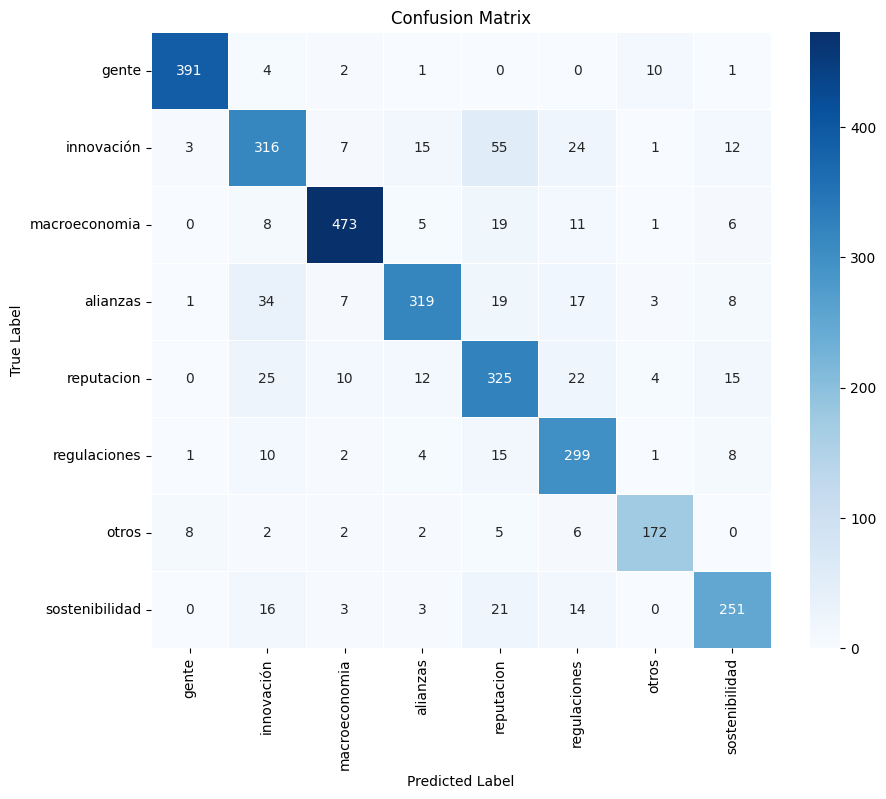

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=label_dict, columns=label_dict)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", linewidths=.5)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Prueba de predicción
titulo_prueba = "Un nuevo avance tecnológico"
texto_prueba = "Este descubrimiento revoluciona la innovación en Europa."
print(predict_category(titulo_prueba, texto_prueba))

innovación
